#Import Libraries

In [6]:
import tensorflow as tf
import tensorflow_hub as hub

#downloads image
import matplotlib.pyplot as plt
import tempfile
from six import BytesIO
from six.moves.urllib.request import urlopen

#draw bounding boxes
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import time
print('Tensorflow Version: ' + tf.__version__)

Tensorflow Version: 2.4.0


#Establish Helper Functions

In [52]:
def display_image(image):
  '''Uses Matplotlib to plot image'''
  figure = plt.figure(figsize = (20,15))
  plt.grid = False
  plt.imshow(image)

def download_resize_img(url, new_width=256, new_height=256, display=False):
  _,filename = tempfile.mkstemp(suffix='jpg') #Creates a unique temporary file

  #load img from url
  response = urlopen(url)
  image_data = response.read()

  image_data = BytesIO(image_data)   #Makes image IO Byte buffer
  pil_img = Image.open(image_data)
  pil_img = ImageOps.fit(pil_img, (new_width, new_height), method=Image.ANTIALIAS) #Returns resized image
  pil_img_rgb = pil_img.convert('RGB')
  pil_img_rgb.save(filename, format='JPEG', quality=90)
  print(f'Image downloaded to {filename}')

  if display:
    display_image(pil_img)
  
  return filename


def bounding_box(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
  '''Draws boxes using input dimensions'''

  draw = ImageDraw.Draw(image)
  i_width, i_height = image.size
  (left, right, top, bottom) = (xmin * i_width, xmax * i_width, ymin * i_height, ymax * i_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

  #Insert Label at the top of the box
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  tot_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > tot_display_str_height: 
    text_bottom = top
  else:
    text_bottom = top + tot_display_str_height

  #reverse list and print from bottom to top
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
    draw.text((left + margin, text_bottom - text_height - margin), display_str, fill='black', font=font)

    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes= 10, min_score = 0.3):
  '''Uses bounding box funtion to draw boxes around objects within an image'''
  colors = list(ImageColor.colormap.values())

  try: 
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)

  except IOError: 
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert('RGB')

      bounding_box(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list = [display_str])
    np.copyto(image, np.array(image_pil))
  return image



In [30]:
def load_img(path):
  '''Loads image from file path'''
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def run_detector(detector, im_path):
  '''Runs the detector on a provided image'''
  img = load_img(im_path)

  converted_image = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis,...] #Converts image to dtype
  start = time.time()
  result = detector(converted_image)
  end = time.time()

  result = {key:value.numpy() for key,value in result.items()} #Creates dictionary of the detection values

  print('Found %d objects.' % len(result['detection_scores']))
  print(f'Detection time: {end - start}')

  image_w_boxes = draw_boxes(img.numpy(), result['detection_boxes'], result['detection_class_entities'], result['detection_scores'])

  display_image(image_w_boxes)

#Run Detection

Image downloaded to /tmp/tmp6r5iuby6jpg


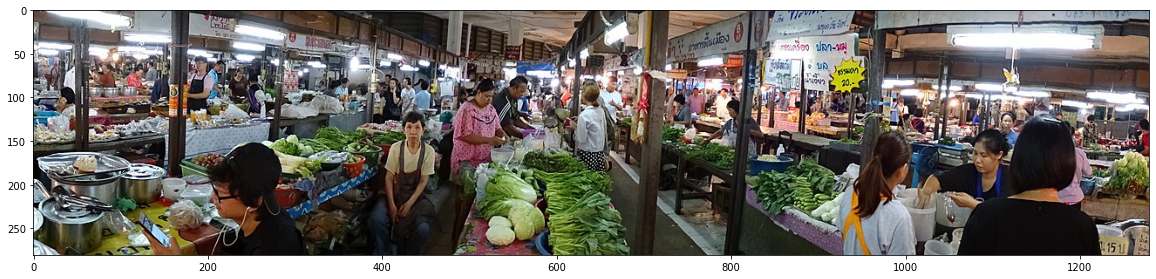

In [50]:
#Load the image
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/Panorama_of_Night_Market_-_Old_Town_-_Lampang_-_Thailand_%2835197212325%29.jpg/1280px-Panorama_of_Night_Market_-_Old_Town_-_Lampang_-_Thailand_%2835197212325%29.jpg" 
downloaded_img_path = download_resize_img(image_url, 1280, 281, True)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Found 100 objects.
Detection time: 55.83482623100281


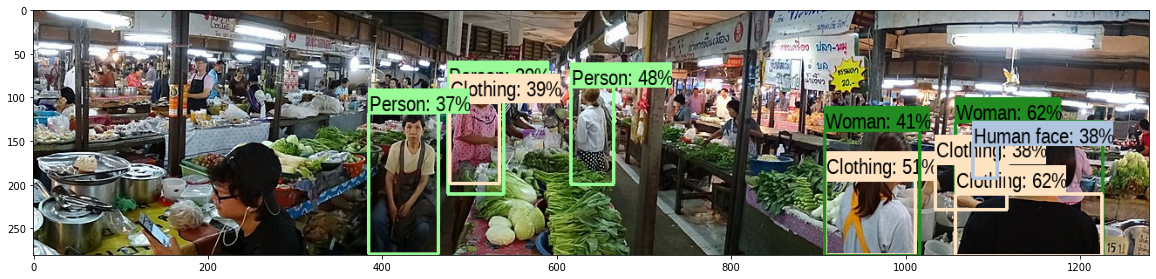

In [53]:
#Load Inception Network

inception = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(inception).signatures['default']

#Run Detector
run_detector(detector, downloaded_img_path)